In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [2]:
# Analyze to load data in batch
# https://stackoverflow.com/questions/61891990/how-to-load-npy-files-from-different-directories-in-tensorflow-data-pipeline-fr

In [3]:
data_path = "./data/train_cnn_features_v2"
train_examples = []
train_labels = []
video_categories = listdir(data_path)
for category in video_categories:
    category_path = data_path+"/"+category
    images_files = listdir(category_path)
    for image in images_files:
        image_path = category_path+"/"+image
        cnn_features = np.load(image_path)["arr_0"]
        train_examples.append(cnn_features)
        train_labels.append(category)

In [4]:
MAX_SEQ_LENGTH = 242
NUM_FEATURES = 1280
EPOCHS = 20
BATCH_SIZE = 128
CLASSES = list(set(train_labels))
N_CLASSES = len(CLASSES)

In [5]:
labels_mapping = dict(zip(CLASSES, range(N_CLASSES)))

In [6]:
train_labels_ids = [labels_mapping[case] for case in train_labels]

In [7]:
labels_one_hot = tf.one_hot(train_labels_ids, N_CLASSES)

In [8]:
X_train, X_test, y_train_ids, y_test_ids = train_test_split(train_examples, train_labels_ids, test_size=0.33, random_state=42)

In [9]:
y_train = tf.one_hot(y_train_ids, N_CLASSES)
y_test = tf.one_hot(y_test_ids, N_CLASSES)

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)
#train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, labels_one_hot)).batch(BATCH_SIZE)

In [11]:
model = keras.Sequential()
model.add(keras.Input(shape=(MAX_SEQ_LENGTH, NUM_FEATURES))) 
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(N_CLASSES*2))
model.add(Dense(N_CLASSES*2))
model.add(Dense(N_CLASSES, activation="softmax"))

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 242, 128)          721408    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
Total params: 803,904
Trainable params: 803,904
Non-trainable params: 0
_________________________________________________________________


In [12]:
filepath = "./trained_models/video_classifier_rnn/"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, 
                                             save_weights_only=True,
                                             save_best_only=True,
                                             verbose=1)
history = model.fit(train_dataset, validation_data=test_dataset, #callbacks=[checkpoint],
                    epochs=EPOCHS)

Epoch 1/20
17/17 [==============================] - 14s 446ms/step - loss: 4.1808 - accuracy: 0.0225 - val_loss: 4.1969 - val_accuracy: 0.0126
Epoch 2/20
17/17 [==============================] - 5s 316ms/step - loss: 4.1664 - accuracy: 0.0177 - val_loss: 4.1761 - val_accuracy: 0.0136
Epoch 3/20
17/17 [==============================] - 5s 324ms/step - loss: 4.1348 - accuracy: 0.0263 - val_loss: 4.1772 - val_accuracy: 0.0223
Epoch 4/20
17/17 [==============================] - 6s 326ms/step - loss: 4.1277 - accuracy: 0.0268 - val_loss: 4.1557 - val_accuracy: 0.0252
Epoch 5/20
17/17 [==============================] - 6s 326ms/step - loss: 4.0696 - accuracy: 0.0321 - val_loss: 4.0577 - val_accuracy: 0.0320
Epoch 6/20
17/17 [==============================] - 5s 321ms/step - loss: 3.9764 - accuracy: 0.0388 - val_loss: 4.0315 - val_accuracy: 0.0301
Epoch 7/20
17/17 [==============================] - 5s 320ms/step - loss: 3.9657 - accuracy: 0.0402 - val_loss: 3.9502 - val_accuracy: 0.0398
Epoch

In [13]:
predictions_test = model.predict(np.array(X_test))

In [14]:
predictions_class_test = np.argmax(predictions_test, axis =1)

In [15]:
y_true = y_test_ids
y_pred =  predictions_class_test
# Confusion matrix for actual and predicted values.
cm = confusion_matrix(y_true, y_pred)

In [16]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = CLASSES, 
                     columns = CLASSES)

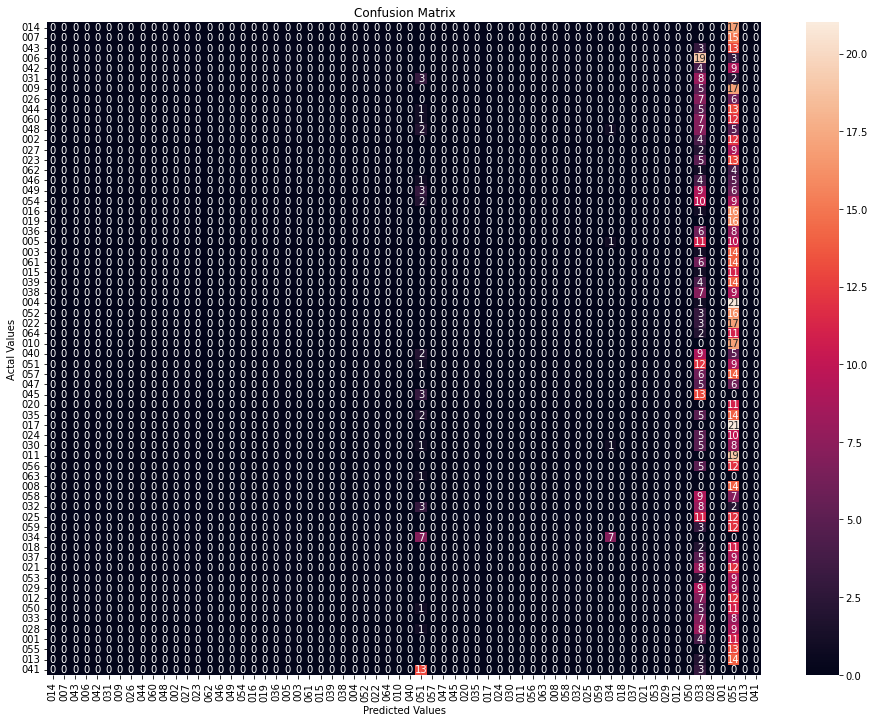

In [17]:
#Plotting the confusion matrix
plt.figure(figsize=(16,12))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
